# Can figure out substrate uptake hierarchy without running the whole simulation

# Match individual growth rates first
# Using coarse model

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['svg.fonttype'] = 'none'
pd.set_option('display.max_colwidth', -1)
%matplotlib inline

In [2]:
PROTOTYPE = False

In [3]:
from dynamicme.tests.helpme import HelpME
from dynamicme.dynamic import get_cplx_concs

helper = HelpME(prototyping=PROTOTYPE)
solver = helper.solver
me = solver.me

## Change keffs until uptake hierarchy correct

In [4]:
import numpy as np

df_dh = pd.read_csv('/home/laurence/ME/data/DHeckmann/kappmax_rf_dl_iJO.csv')

import re
from cobra.io import load_json_model

ijo = load_json_model('/home/laurence/ME/models/BiGG_M/json/iJO1366.json')

rows = []
biggids = df_dh['bigg.id'].apply(lambda x: re.sub(r'(_[b|f]$)', '',x)).unique()
missed = []
for biggid in biggids:
    try:
        sdata = me.stoichiometric_data.get_by_id(biggid)
        mrxn = ijo.reactions.get_by_id(biggid)
        rname = mrxn.name        
        for rxn in sdata.parent_reactions:
            mmol_gDW = rxn.x / rxn.keff / 3600
            rows.append({'bigg_id':biggid, 'rxn':rxn.id, 'name':rname, 'keff_nominal':rxn.keff, 'subsystem':mrxn.subsystem, 'reaction':mrxn.reaction, 'mmol_gDW':mmol_gDW})
    except KeyError:
        missed.append(biggid)
        
df_rmap = pd.DataFrame(rows)
        
print 'biggids not mapped:', len(missed)

biggids not mapped: 252


In [5]:
print 'Subsystems:', len(df_rmap.subsystem.unique())
print 'Rxns within alternate carbon metab:', len(df_rmap.rxn[ df_rmap.subsystem=='Alternate Carbon Metabolism'])

ProtM = df_rmap.mmol_gDW.sum()
print 'Expressed protein (mmol/gDW):', ProtM

Subsystems: 35
Rxns within alternate carbon metab: 285
Expressed protein (mmol/gDW): 0.00495155284852


In [6]:
%%time

KEFF_SCALE = 0.32

from cobra import Metabolite, Reaction

ijomc = load_json_model('/home/laurence/ME/models/BiGG_M/json/iJO1366.json')

cons_crowding = Metabolite('crowding')
ijomc.add_metabolites([cons_crowding])

# sum_j v/keff  <= P [mmol/gDW]

for rid in df_rmap.bigg_id.unique():    
    dfi = df_rmap[ df_rmap.bigg_id==rid]
    keff_nom = dfi['keff_nominal'].mean()
    rxn = ijomc.reactions.get_by_id(rid)
    if rxn.lower_bound < 0:
        rxn_abs = Reaction(rxn.id + '_abs')
        ijomc.add_reaction(rxn_abs)
        # rabs >= r  :  rabs - r >= 0
        # rabs >= -r :  rabs + r >= 0        
        cons_abs_p = Metabolite('cons_'+rxn.id+'_abs_p')
        cons_abs_n = Metabolite('cons_'+rxn.id+'_abs_n')
        cons_abs_p._constraint_sense = 'G'
        cons_abs_n._constraint_sense = 'G'
        rxn_abs.add_metabolites({cons_abs_p: 1., cons_abs_n: 1.})
        rxn.add_metabolites({cons_abs_p:-1., cons_abs_n:1.})
        keff = keff_nom * KEFF_SCALE
        rxn_abs.add_metabolites({cons_crowding:1./keff/3600 })
    else:
        rxn.add_metabolites({cons_crowding:1./keff_nom/3600})

cons_crowding._constraint_sense = 'L'
cons_crowding._bound = ProtM

CPU times: user 1.65 s, sys: 3.33 ms, total: 1.65 s
Wall time: 1.65 s


In [7]:
ijomc.optimize(solver='gurobi')

<Solution 0.74 at 0x7f17536fa350>

In [8]:
df_meas = pd.read_csv('/home/laurence/ME/data/dynamicME/beg/growth_meas.csv')

In [9]:
rank_meas = {'EX_ac_e': 5,
             'EX_gal_e': 2,
             'EX_glc__D_e': 0,
             'EX_glyc_e': 4,
             'EX_lac__L_e': 1,
             'EX_malt_e': 3
            }    

In [10]:
%%time

mrows = []
ZERO = 1e-8

for ex_id in rank_meas.keys():
    # Reset first
    for rid in rank_meas.keys():
        rxn = ijomc.reactions.get_by_id(rid)
        rxn.lower_bound = 0.
    rxn = ijomc.reactions.get_by_id(ex_id)
    rxn.lower_bound = -10
    ijomc.optimize()
    mmu = ijomc.reactions.BIOMASS_Ec_iJO1366_core_53p95M.x
    # Was the MC constraint active?
    tot_prot = sum([r.x*r.metabolites[cons_crowding] for r in cons_crowding.reactions])
    mrows.append({'muopt':mmu, 'ex_rxn':ex_id, 'tot_prot':tot_prot, 'crowding_active':abs(cons_crowding._bound - tot_prot)<ZERO})

CPU times: user 4.3 s, sys: 10 ms, total: 4.31 s
Wall time: 4.31 s


In [11]:
df_ijo = pd.DataFrame(mrows)

Pearson r=0.936904 (p=0.00584603)
Spearman r=0.942857 (p=0.00480466)


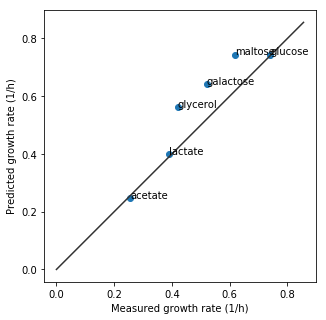

In [12]:
import scipy.stats as stats

df_val = pd.merge(df_ijo, df_meas, on='ex_rxn')
xymax = max(df_val.growth_rate_1_h.max(), df_val.muopt.max())
plt.plot([0, xymax*1.15], [0, xymax*1.15], color='#333333')
plt.scatter(df_val.growth_rate_1_h, df_val.muopt)
for i,r in df_val.iterrows():
    x = r['growth_rate_1_h']
    y = r['muopt']
    k = r['substrate']
    ls = plt.text(x, y, k)
ax = ls.axes
ax.set_aspect(1)
ax.figure.set_size_inches(5,5)
ax.set_xlabel('Measured growth rate (1/h)')
ax.set_ylabel('Predicted growth rate (1/h)')

r,p = stats.pearsonr(df_val.growth_rate_1_h, df_val.muopt)
print 'Pearson r=%g (p=%g)' % (r,p)
r,p = stats.spearmanr(df_val.growth_rate_1_h, df_val.muopt)
print 'Spearman r=%g (p=%g)' % (r,p)

# Metaheuristics on small model to get growth rates right

In [13]:
df_exp = df_meas[ df_meas.ex_rxn.isin(rank_meas.keys())]
meas_dict = {r['ex_rxn']:r['growth_rate_1_h'] for i,r in df_exp.iterrows()}

In [14]:
def sim_fun(mdl):
    mu_id = 'BIOMASS_Ec_iJO1366_core_53p95M'
    sim_dict = {}
    for ex_id in meas_dict.keys():
        # Reset first
        for rid in meas_dict.keys():
            rxn = mdl.reactions.get_by_id(rid)
            rxn.lower_bound = 0.
        rxn = mdl.reactions.get_by_id(ex_id)
        rxn.lower_bound = -10
        mdl.optimize(solver='gurobi')
        try:
            mmu = mdl.reactions.get_by_id(mu_id).x
        except Exception:
            mmu = 0.
        sim_dict[ex_id] = mmu
    
    return sim_dict

In [15]:
def obj_fun(y_sim, y_meas):
    ### Objective function    
    sse = sum([ (y - y_sim[r])**2 for r,y in y_meas.iteritems()]) 
    
    return sse

In [16]:
def get_param_fun(mdl):
    cons_id = 'crowding'
    cons = mdl.metabolites.get_by_id(cons_id)
    params = [r.metabolites[cons] for r in cons.reactions]
    
    return params

def set_param_fun(mdl, xs):
    cons_id = 'crowding'
    cons = mdl.metabolites.get_by_id(cons_id)
    for j,rxn in enumerate(cons.reactions):
        rxn._metabolites[cons] = xs[j]

In [17]:
y0 = sim_fun(ijomc)
obj_fun(y0, meas_dict)

0.05053795959737954

In [18]:
import copy as cp

mdl2 = cp.deepcopy(ijomc)

from dynamicme.metaopt import LocalMove

mover = LocalMove(get_param_fun, set_param_fun)

In [19]:
from dynamicme.metaopt import MetaOpt

In [20]:
mopt = MetaOpt(mdl2, sim_fun, obj_fun, get_param_fun, set_param_fun)

In [49]:
%%time
result = mopt.optimize(meas_dict, max_iter_phase1=20, max_reject=40)

[Phase I] Iter 1:	 Performing local move: <class 'dynamicme.metaopt.LocalMove'>
Obj:0.0414481 	 Best Obj: 0.0277575 	 Tmax:1 	 T:0.0133208 	 Time:1.78251 secs
y= {'EX_glyc_e': 0.552759706332709, 'EX_gal_e': 0.6365401933107427, 'EX_lac__L_e': 0.39908018013497715, 'EX_malt_e': 0.6934239468916892, 'EX_ac_e': 0.24719886868344346, 'EX_glc__D_e': 0.6715140666453033}
//============================================
[Phase I] Iter 2:	 Performing local move: <class 'dynamicme.metaopt.LocalMove'>
Obj:0.0609522 	 Best Obj: 0.0277575 	 Tmax:1 	 T:0.0322982 	 Time:0.804127 secs
y= {'EX_glyc_e': 0.41604693595699177, 'EX_gal_e': 0.4907104662633948, 'EX_lac__L_e': 0.3990808376807661, 'EX_malt_e': 0.5251162343412443, 'EX_ac_e': 0.2471988686834438, 'EX_glc__D_e': 0.5143545874273996}
//============================================
[Phase I] Iter 3:	 Performing local move: <class 'dynamicme.metaopt.LocalMove'>
Obj:0.0626105 	 Best Obj: 0.0277575 	 Tmax:1 	 T:0.0339117 	 Time:0.813618 secs
y= {'EX_glyc_e': 0.

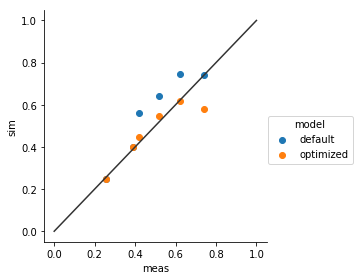

In [50]:
ex_ids = meas_dict.keys()
y_sim0 = sim_fun(ijomc)
y_best = result[0]
df0 = pd.DataFrame([{'rxn':k, 'meas':meas_dict[k], 'sim':y_sim0[k], 'model':'default'} for k in ex_ids])
df1 = pd.DataFrame([{'rxn':k, 'meas':meas_dict[k], 'sim':y_best[k], 'model':'optimized'} for k in ex_ids])
df_val = pd.concat([df0, df1])

g = sns.FacetGrid(df_val, hue='model', size=4)
g.map(plt.scatter, 'meas', 'sim')
g.add_legend()
ax = g.axes.flatten()[0]
ax.plot([0,1], [0,1], color='#333333', zorder=1)

In [52]:
df_val.groupby('model').apply(lambda x: obj_fun(x['meas'], x['sim'])).reset_index()

,model,0
0,default,0.050538
1,optimized,0.027758


In [47]:
df_val.groupby('model').apply(lambda x: obj_fun(x['meas'], x['sim'])).reset_index()

,model,0
0,default,0.050538
1,optimized,0.024015
